In [21]:
# Import modules

# General
import os
import random
import time
from tqdm import tqdm

# Data processing, storage
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Image processing
import cv2 # opencv-python
from PIL import Image

# Data plotting
import matplotlib.pyplot as plt

# Machine learning
import tensorflow as tf
from sklearn import metrics

### Setup the GPU memory growth

In [2]:
### Taken from- https://github.com/tensorflow/tensorflow/issues/34695
### This was done to resolve the error: "Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


### Setup initial parameters

In [3]:
#test_data_dir = '../P7-sample-tiles-2'
test_data_dir = '../P7-sample-tiles-3' # This one was used for the final surface reconstruction


# Calculation of max batch size-
# Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
# size of tensors = batch_size*100*100 *4 if using 64 bit integers

batch_size = 64#256
test_batch_size = 64#256
img_height = 300
img_width = 300
channels = 1
#mean = 157.1
#std = 64.6
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Create datasets

In [4]:
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir+'/*'), shuffle=False)
# get the count of image files in the train directory
test_image_count = 0
for files in os.listdir(test_data_dir):
    test_image_count+=1
print("Test image count:", test_image_count)

Test image count: 15636


In [5]:
# Print some filenames
for x in test_list_ds.take(5):
    print(x.numpy().decode('utf-8'))

../P7-sample-tiles-3/R_(1850,1150,400).png
../P7-sample-tiles-3/R_(1850,1150,500).png
../P7-sample-tiles-3/R_(1850,1250,0).png
../P7-sample-tiles-3/R_(1850,1250,100).png
../P7-sample-tiles-3/R_(1850,1250,1100).png


In [6]:
# Use this function to list files from a filelist dataset, such as test_list_ds.
# This may be useful later
list_files_from_tfdataset = lambda tfd: [f.numpy().decode('utf-8') for f in tfd]

In [7]:
# Create test dataset
test_ds = test_list_ds.take(test_image_count)

In [8]:
for x in test_ds.take(3):
    print(x.numpy().decode('utf-8'))

../P7-sample-tiles-3/R_(1850,1150,400).png
../P7-sample-tiles-3/R_(1850,1150,500).png
../P7-sample-tiles-3/R_(1850,1250,0).png


### Create input pipeline components

In [9]:
# To process the image
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    #img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.decode_png(img, channels=channels)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

# To create the single training of validation example with image and its corresponding label
def process_path(filepath):
    # load the raw data from the file as a string
    img = tf.io.read_file(filepath)
    img = decode_img(img)
    return img

In [10]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
# Test if the datasets are prepared correctly
for images in test_ds.take(1):
    print(images.shape)
    img = images[0].numpy()
    print(img.min(), img.max(), img.dtype)
    img = (img-5)/2 # Testing mathematical operations on tensor
    print(img.min(), img.max(), img.dtype)

(300, 300, 1)
70.0 218.0 float32
32.5 106.5 float32


In [12]:
def standardize_per_image(image):
    img = tf.image.per_image_standardization(image)
    return img

def standardize_dataset(image):
    # NOTE: mean and std have to be defined globally
    # Not checking that mean and std are > 0 to avoid time lag. So be careful with the values of mean and std.
    img = (image - mean)/std
    return img

In [13]:
def configure_for_performance_forTestDataset(ds, cache_filename=''):
    if cache_filename == '':
        ds = ds.cache()
    else:
        ds = ds.cache(cache_filename)
    #ds = ds.shuffle(buffer_size=10000)
    ds = ds.map(standardize_per_image, num_parallel_calls=AUTOTUNE) # Use either of the two standardizations.
    #ds = ds.map(standardize_dataset, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(test_batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

test_ds = configure_for_performance_forTestDataset(test_ds, cache_filename='')#, '/home/harsh/tensorflow_cache/train_v5.test_ds')

(64, 300, 300, 1)
-4.4803925 2.4727256 float32


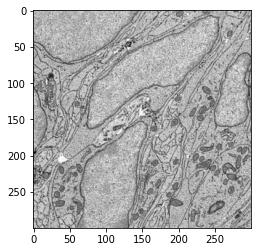

In [14]:
# Test that the pixels values are actually standardized and the images are properly stored.
for images in test_ds.take(1):
    print(images.shape)
    img = images[0].numpy()
    print(img.min(), img.max(), img.dtype)
    plt.imshow(img, cmap=plt.get_cmap("gray"))

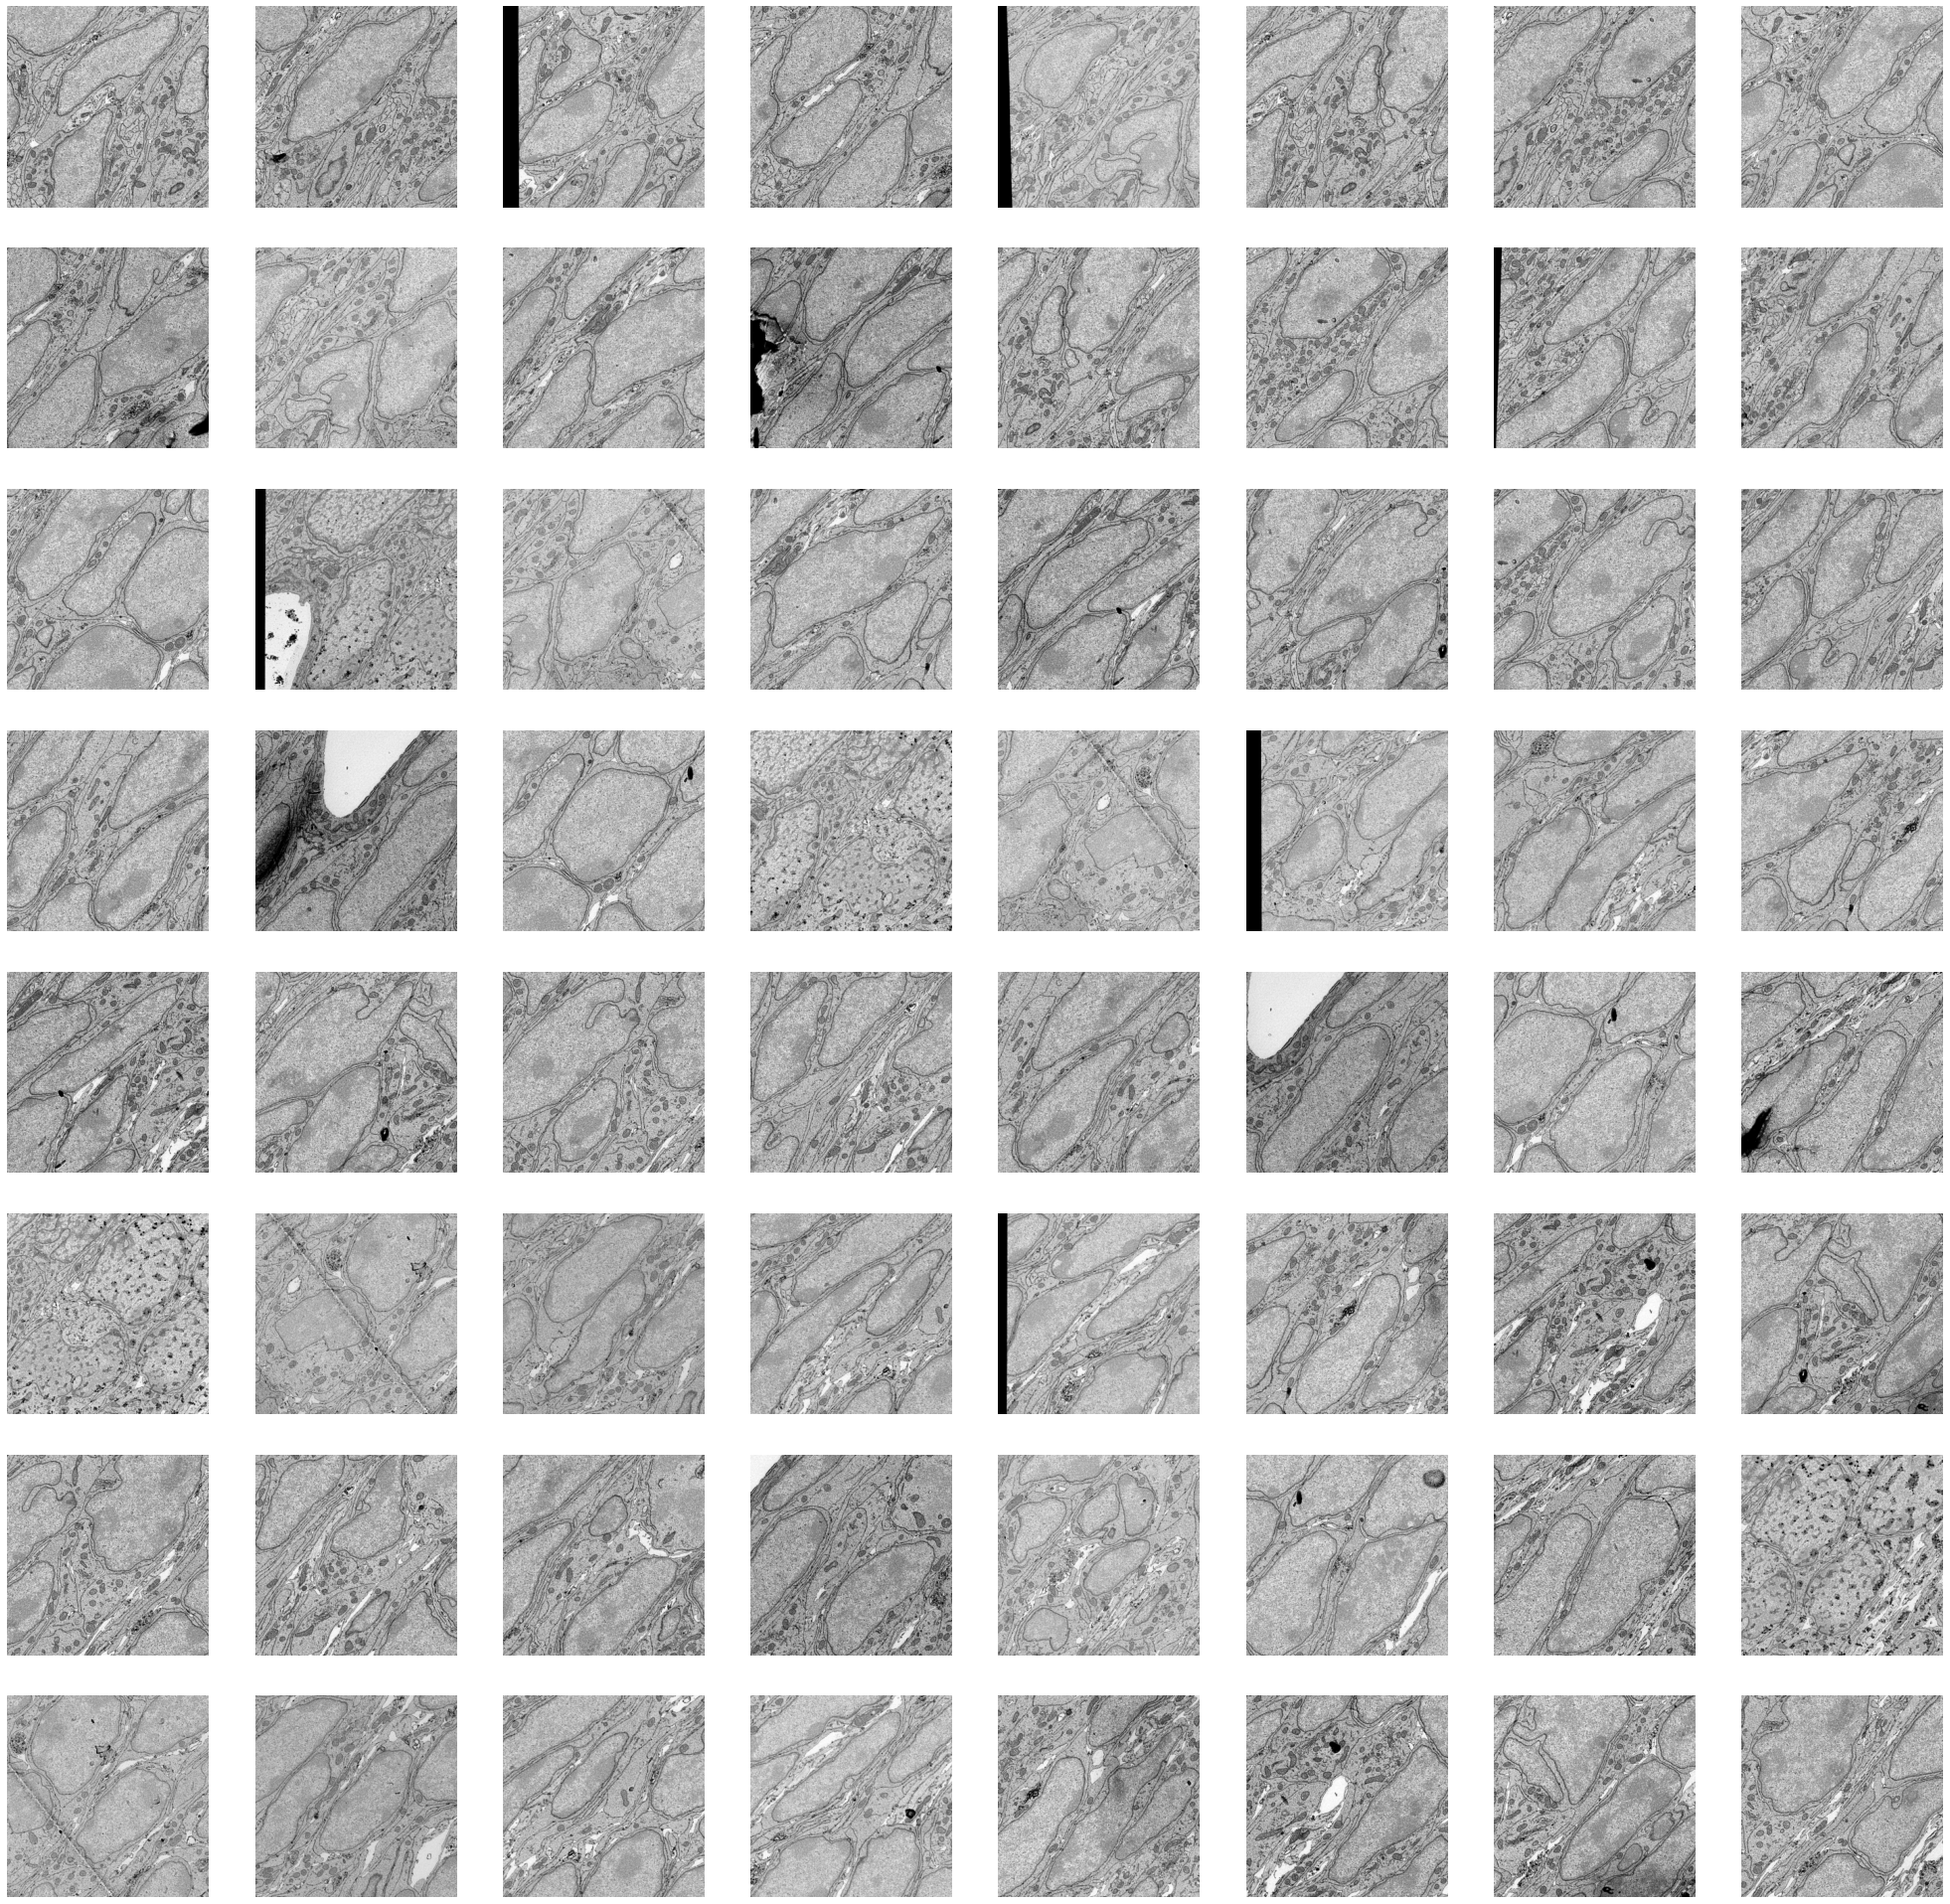

In [15]:
# Check if a batch of images from test dataset can be printed along with classnames and filenames
plt.figure(figsize=(35, 35))
cnt = 0
for images in test_ds.take(1):
    #print(images.shape)
    for i in range(batch_size):
        ax = plt.subplot(int(np.sqrt(batch_size)), int(np.sqrt(batch_size)), i + 1)
        #ax = plt.subplot(16, 16, i + 1)
        #print(images[i].shape)
        plt.imshow(images[i].numpy(), cmap=plt.get_cmap("gray"))
        #plt.title(class_names[labels[i]])
        #plt.title(class_names[labels[i]]+"\n"+test_ds_filelist[i+cnt*batch_size].split("/")[-1].replace(".png",""))
        plt.axis("off")
    cnt += 1

In [16]:
#Define model
def create_model():
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 1)),
            ###keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(32,(3,3), padding="same", activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(32,(3,3), padding="same", activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64,(3,3), padding="same", activation='relu'),
            tf.keras.layers.MaxPool2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    #Compile the model
    model.compile(
                  optimizer=opt, 
                  #optimizer='adam', 
                  loss='binary_crossentropy',
                  #loss='categorical_crossentropy',
                  metrics=['acc']
                  #metrics=['accuracy', 'f1score', 'precision', 'recall']
                 )

    return(model)

In [17]:
# Create model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0

In [18]:
# Define checkpoint directory where all the checkpoints of the model are stored
checkpoint_dir = "model_checkpoints"

In [19]:
# Load weights from latest checkpoint or a specific checkpoint

# Latest checkpoint
#latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
#latest_cp
#model.load_weights(latest_cp)

# Specific checkpoint
checkpoint = checkpoint_dir + '/model.0019.ckpt'
model.load_weights(checkpoint)

### Predict

In [27]:
tic = time.time()
pred = model.predict(test_ds)
toc = time.time()
print("Time taken = ", toc-tic)

  0%|          | 0/15636 [05:52<?, ?it/s]


Time taken =  6.8788743019104


In [64]:
# Check the number of predictions made
pred.shape

(15636, 1)

In [65]:
# Generate filelist dataset
test_files = list_files_from_tfdataset(test_list_ds)

In [66]:
len(test_files)

15636

### Generate coordinates for predicted ML tiles

In [67]:
ml_coord = []
ml_coord_fnames = []
for name, p in zip(test_files,pred):
    #print(name,p)
    if p[0]>=0.9:
        [x,y,z] = [int(v) for v in name.split("(")[1].split(")")[0].split(",")]
        ml_coord.append([x,y,z])
        ml_coord_fnames.append(name)
ml_coord = np.array(ml_coord)
ml_coord.shape

(5163, 3)

In [25]:
# This is optional.
# Print commands to copy files from one directory to other.
#dest = 'P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/'
#print("\n".join(['cp ' + os.path.basename(v) + ' ../' + dest for v in ml_coord_fnames]))

cp R_(2050,5250,2200).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/
cp R_(2050,5250,2300).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/
cp R_(2050,5550,1700).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/
cp R_(2150,5150,2200).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/
cp R_(2150,5250,2200).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/
cp R_(2150,5250,2300).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/
cp R_(2150,5350,2200).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/
cp R_(2150,5350,2300).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/
cp R_(2150,5450,1900).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/
cp R_(2150,5450,2100).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/
cp R_(2150,5450,2200).png ../P7-sample-tiles-3_egl-ml-200regions-clean-cnn1_predicted-EGL/

In [68]:
# Note: These coordinates represent [height, width, slice] order.
# Check the predicted ML tile cooordinates
ml_coord

array([[2050, 5250, 2200],
       [2050, 5250, 2300],
       [2050, 5550, 1700],
       ...,
       [3750, 3350,  500],
       [3750, 4250,  500],
       [3750, 4550,  600]])

In [69]:
# Scale factor to convert from nm to um
scale = 0.001

In [70]:
5*scale

0.005

In [71]:
# Import open3d for point-cloud processing
import open3d as o3d

In [72]:
# Change the scale of the coordinates from pixels to micrometers
# Note the anisotropy in the voxel size in nanometers
data = ml_coord*np.array([32,32,30])*np.array([scale,scale,-scale])
print("data.shape:", data.shape)
print("nonzero:", np.array(np.nonzero(data)).shape)

data.shape: (5163, 3)
nonzero: (2, 15298)


In [73]:
# Generate a point-cloud object
pcd = o3d.geometry.PointCloud()

# Load data into the point-cloud
pcd.points = o3d.utility.Vector3dVector(data[:,:3])

# Assign normals to the points such that they face the direction of EGL
pcd.normals = o3d.utility.Vector3dVector(np.zeros((data.shape[0],3))+np.array([-1,0,0]))

In [74]:
# Decide the radius for the ball-pivoting algorithm based on the distances between neighboring points
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist
avg_dist, radius

(3.0319389916593575, 9.095816974978073)

In [75]:
# Optional normal estimation
#o3d.geometry.estimate_normals(pcd, search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius,max_nn=30))

In [76]:
#pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius,max_nn=30))

In [81]:
# Visualize the point-cloud
o3d.visualization.draw_geometries([pcd])

In [78]:
# Create a surface mesh using ball-pivoting algorithm
bpa_mesh = \
o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd,
    o3d.utility.DoubleVector([2*radius, radius * 3]))

In [ ]:
# Visualize the surface mesh
o3d.visualization.draw_geometries([bpa_mesh])

In [80]:
# Export the surface mesh as .ply file (Stanford format)
o3d.io.write_triangle_mesh("mlsurfacemesh_bpa_22-09-2021_sample_tiles3.ply", bpa_mesh)

True

### -------------- END OF THE NOTEBOOK --------------

### Rough work ahead ...

In [6]:
# Check point cloud
#pcd

#### Alpha shape reconstruction

In [68]:
#tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(pcd)

In [5]:
#alpha=0.500
#mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha, tetra_mesh, pt_map)
#mesh.compute_vertex_normals()

In [4]:
#o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

#### Poisson surface reconstruction

In [1]:
#print('run Poisson surface reconstruction')
#with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
#    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=5)
#print(mesh)

In [2]:
#o3d.visualization.draw_geometries([mesh],
#                                  zoom=0.664,
#                                  front=[-0.4761, -0.4698, -0.7434],
#                                  lookat=[1.8900, 3.2596, 0.9284],
#                                  up=[0.2304, -0.8825, 0.4101])

In [3]:
#o3d.io.write_triangle_mesh("mlsurfacemesh_poisson.ply", mesh)